In [51]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import utils

In [52]:
learning_rate_anr_capex = 0
learning_rate_h2_capex = 0
csv_path = './results/ammonia_anr_lr_'+str(learning_rate_anr_capex)+'_h2_lr_'+str(learning_rate_h2_capex)+'_wacc_'+str(utils.WACC)+'.csv'
clean_save_path = './results/ammonia_anr_lr_'+str(learning_rate_anr_capex)+'_h2_lr_'+str(learning_rate_h2_capex)+'_wacc_'+str(utils.WACC)+'_clean.csv'
save_fig_path = './results/ammonia_anr_lr_'+str(learning_rate_anr_capex)+'_h2_lr_'+str(learning_rate_h2_capex)+'_wacc_'+str(utils.WACC)+'.png'

In [53]:
df = pd.read_csv(csv_path)
df.sort_values(by=['Breakeven NG price ($/MMBtu)'], inplace=True)
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)


In [54]:
anr_param = pd.read_excel('ANRs.xlsx', sheet_name='FOAK')

### Cumulative number of viable ammonia plants and ANR modules

In [55]:
anr_thermal_power = anr_param[['Power in MWt', 'Reactor']]
df = df.merge(anr_thermal_power, how='inner', left_on=['ANR type'], right_on=['Reactor'])
df.sort_values(by=['Breakeven NG price ($/MMBtu)'], inplace=True)
df['Deployed Power (MWt)'] = df['Power in MWt']*df['# ANR modules']
df['ANR Nameplate Capacity (GWt)'] = df['Deployed Power (MWt)'].cumsum()/1000
df['Cum h2 dem (t/day)'] =df['H2 Dem (kg/day)'].cumsum()/1000
df.tail(10)

,plant_id,state,Ammonia capacity (tNH3/year),H2 Dem (kg/day),Aux Elec Dem (MWe),Net Rev. ($/year),PEM,Alkaline,HTSE,Ann. CO2 emissions (kgCO2eq/year),...,ANR CRF,Depl. ANR Cap. (MWe),ANR type,# ANR modules,Breakeven NG price ($/MMBtu),Power in MWt,Reactor,Deployed Power (MWt),ANR Nameplate Capacity (GWt),Cum h2 dem (t/day)
25,Co_E.,IL,350000.0,483970.750863,4.754566,-2.811254e+08,0,0,484.0,4.375515e+07,...,0.086325,480.0,PBR-HTGR,6,26.002125,200,PBR-HTGR,1200,48.60,23624.686510
26,Dy_Ch,WY,175000.0,241985.375431,2.377283,-1.428113e+08,0,0,242.0,2.187757e+07,...,0.086325,240.0,PBR-HTGR,3,26.419039,200,PBR-HTGR,600,49.20,23866.671885
27,Ko_Fo,OA,340000.0,470143.015124,4.618721,-2.800124e+08,0,0,471.0,4.257991e+07,...,0.086325,480.0,PBR-HTGR,6,26.662419,200,PBR-HTGR,1200,50.40,24336.814901
28,LS_Ch,AL,170000.0,235071.507562,2.309361,-1.422976e+08,0,0,236.0,2.133516e+07,...,0.086325,240.0,PBR-HTGR,3,27.099766,200,PBR-HTGR,600,51.00,24571.886408
29,Au_Gr,TN,60000.0,82966.414434,0.815068,-5.080173e+07,0,0,83.0,7.503466e+06,...,0.086325,80.0,PBR-HTGR,1,27.412896,200,PBR-HTGR,200,51.20,24654.852823
30,U._Mo,TN,60000.0,82966.414434,0.815068,-5.080173e+07,0,0,83.0,7.503466e+06,...,0.086325,80.0,PBR-HTGR,1,27.412896,200,PBR-HTGR,200,51.40,24737.819237
21,Ne_Ge,NE,90000.0,124449.621650,1.222603,-7.664651e+07,0,0,125.0,1.172351e+07,...,0.086325,141.0,iMSR,1,27.572937,300,iMSR,300,51.70,24862.268859
31,Gr_Cr,IA,32000.0,44248.754365,0.434703,-3.861739e+07,0,0,45.0,3.386020e+06,...,0.086325,33.5,Micro,5,39.096806,20,Micro,100,51.80,24906.517613
32,Ch_El,CA,25000.0,34569.339347,0.339612,-3.172210e+07,0,0,35.0,2.633571e+06,...,0.086325,26.8,Micro,4,41.111422,20,Micro,80,51.88,24941.086952
33,Sh_Go,GA,30000.0,41483.207217,0.407534,-3.840360e+07,0,0,42.0,3.160286e+06,...,0.086325,33.5,Micro,5,41.475991,20,Micro,100,51.98,24982.570160


In [56]:
df['Viable ANR modules count'] = df['# ANR modules'].cumsum()
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)
df['Viable ANR ammonia plants count'] = df.index+1
df.tail(10)

,plant_id,state,Ammonia capacity (tNH3/year),H2 Dem (kg/day),Aux Elec Dem (MWe),Net Rev. ($/year),PEM,Alkaline,HTSE,Ann. CO2 emissions (kgCO2eq/year),...,ANR type,# ANR modules,Breakeven NG price ($/MMBtu),Power in MWt,Reactor,Deployed Power (MWt),ANR Nameplate Capacity (GWt),Cum h2 dem (t/day),Viable ANR modules count,Viable ANR ammonia plants count
24,Co_E.,IL,350000.0,483970.750863,4.754566,-2.811254e+08,0,0,484.0,4.375515e+07,...,PBR-HTGR,6,26.002125,200,PBR-HTGR,1200,48.60,23624.686510,172,25
25,Dy_Ch,WY,175000.0,241985.375431,2.377283,-1.428113e+08,0,0,242.0,2.187757e+07,...,PBR-HTGR,3,26.419039,200,PBR-HTGR,600,49.20,23866.671885,175,26
26,Ko_Fo,OA,340000.0,470143.015124,4.618721,-2.800124e+08,0,0,471.0,4.257991e+07,...,PBR-HTGR,6,26.662419,200,PBR-HTGR,1200,50.40,24336.814901,181,27
27,LS_Ch,AL,170000.0,235071.507562,2.309361,-1.422976e+08,0,0,236.0,2.133516e+07,...,PBR-HTGR,3,27.099766,200,PBR-HTGR,600,51.00,24571.886408,184,28
28,Au_Gr,TN,60000.0,82966.414434,0.815068,-5.080173e+07,0,0,83.0,7.503466e+06,...,PBR-HTGR,1,27.412896,200,PBR-HTGR,200,51.20,24654.852823,185,29
29,U._Mo,TN,60000.0,82966.414434,0.815068,-5.080173e+07,0,0,83.0,7.503466e+06,...,PBR-HTGR,1,27.412896,200,PBR-HTGR,200,51.40,24737.819237,186,30
30,Ne_Ge,NE,90000.0,124449.621650,1.222603,-7.664651e+07,0,0,125.0,1.172351e+07,...,iMSR,1,27.572937,300,iMSR,300,51.70,24862.268859,187,31
31,Gr_Cr,IA,32000.0,44248.754365,0.434703,-3.861739e+07,0,0,45.0,3.386020e+06,...,Micro,5,39.096806,20,Micro,100,51.80,24906.517613,192,32
32,Ch_El,CA,25000.0,34569.339347,0.339612,-3.172210e+07,0,0,35.0,2.633571e+06,...,Micro,4,41.111422,20,Micro,80,51.88,24941.086952,196,33
33,Sh_Go,GA,30000.0,41483.207217,0.407534,-3.840360e+07,0,0,42.0,3.160286e+06,...,Micro,5,41.475991,20,Micro,100,51.98,24982.570160,201,34


### Avoided carbon emissions

In [57]:
ammonia_demand_df = pd.read_excel('./h2_demand_ammonia_us_2022.xlsx', sheet_name='processed')
df = df.merge(ammonia_demand_df, on='plant_id')
ratio_co2_to_nh3 = 2.30 # tCO2eq/tNH3
df['NG path GHG (tCO2/year)'] = df.apply(lambda x:x['Capacity (tNH3/year)']*2.30, axis=1)

In [58]:
df['Ann. avoided CO2 emissions (MMT-CO2/year)'] = (df['NG path GHG (tCO2/year)'] - (df['Ann. CO2 emissions (kgCO2eq/year)']/1e3))/1e6
df['Viable avoided emissions (MMT-CO2/year)'] = df['Ann. avoided CO2 emissions (MMT-CO2/year)'].cumsum()
df[['Breakeven NG price ($/MMBtu)', 'Viable avoided emissions (MMT-CO2/year)']].tail(50)


,Breakeven NG price ($/MMBtu),Viable avoided emissions (MMT-CO2/year)
0,21.581213,8.540105
1,21.634143,10.742927
2,22.062416,11.708653
3,22.067656,14.095908
4,22.192122,14.584146
5,22.241622,16.244418
6,22.380677,16.960557
7,22.478205,17.904597
8,22.711285,19.065694
9,22.913561,19.988046


### Save

In [59]:
df_clean = df[["plant_id", 'state', 'Capacity (tNH3/year)', 'H2 Dem (kg/day)', 'HTSE', 'ANR type', '# ANR modules', 'Net Rev. ($/year)', 'Ann. avoided CO2 emissions (MMT-CO2/year)', 'Breakeven NG price ($/MMBtu)', 'Viable avoided emissions (MMT-CO2/year)']]
df_clean['H2 Dem (kg/day)'] /=1e3

df_clean['HTSE'] = df_clean['HTSE'].apply(lambda x: int(x))

df_clean['H2 Dem (kg/day)'] = df_clean['H2 Dem (kg/day)'].apply(lambda x:np.round(x,1))

df_clean['Avoided cost of CO2 ($/ton)'] = df_clean['Net Rev. ($/year)']/(1e6*df_clean['Ann. avoided CO2 emissions (MMT-CO2/year)'])
df_clean['Avoided cost of CO2 ($/ton)'] = df_clean['Avoided cost of CO2 ($/ton)'].apply(lambda x:np.round(np.abs(x),1))

df_clean['Net Rev. ($/year)'] = df_clean['Net Rev. ($/year)'].apply(lambda x: np.round(x/1e6,1))

df_clean['Ann. avoided CO2 emissions (MMT-CO2/year)']= df_clean['Ann. avoided CO2 emissions (MMT-CO2/year)'].apply(lambda x: np.round(x,1))

df_clean['Breakeven NG price ($/MMBtu)'] = df_clean['Breakeven NG price ($/MMBtu)'].apply(lambda x : np.round(x,1))

df_clean.rename(columns={'H2 Dem (kg/day)': 'Demand (MT H2/day)',
                         'Net Rev. ($/year)': 'Net Rev. (M$/year)', 
                         'ANR type': 'ANR', 
                         '# ANR modules': '#'}, inplace=True)
df_clean.to_csv(clean_save_path, index=False)

C:\Users\mgarrou\AppData\Local\Temp\ipykernel_2260\1030162951.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['H2 Dem (kg/day)'] /=1e3
C:\Users\mgarrou\AppData\Local\Temp\ipykernel_2260\1030162951.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['HTSE'] = df_clean['HTSE'].apply(lambda x: int(x))
C:\Users\mgarrou\AppData\Local\Temp\ipykernel_2260\1030162951.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

### Plots

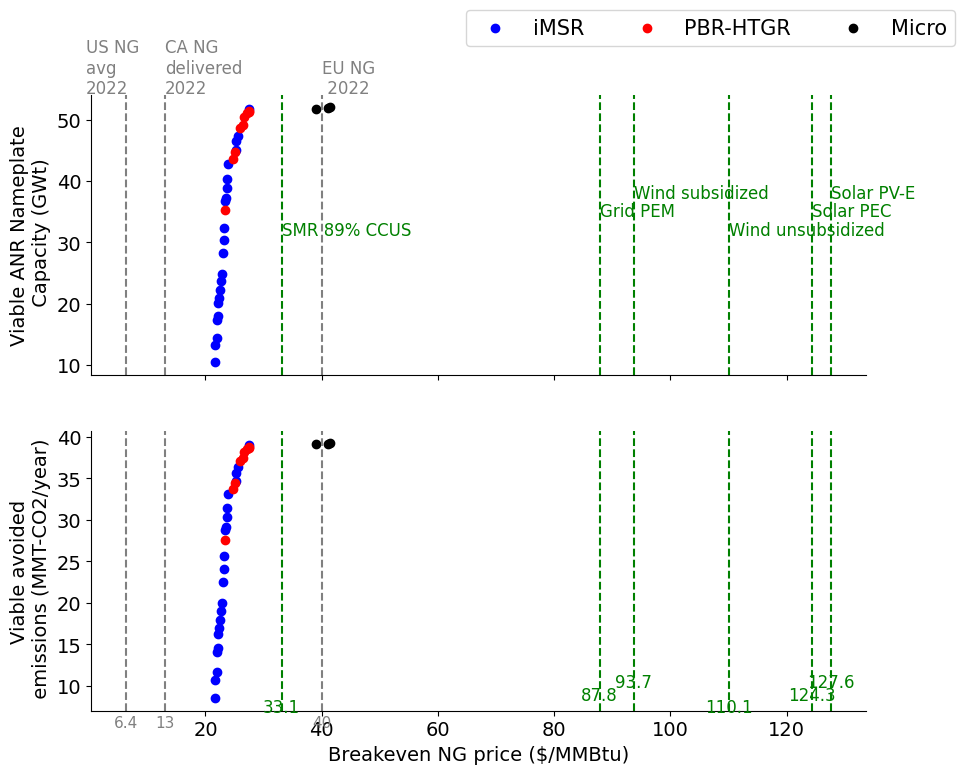

In [60]:
#Use latex font
#plt.rcParams['text.usetex'] = True
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['font.size'] = 14

# Create subplots
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

# Get unique ANR types and assign colors
anr_types = df['ANR type'].unique()

colors = ['blue', 'red', 'black']  # Adjust the colors according to the unique ANR types
# Initialize empty handles for legend
handles = []
# Plotting the data as scatter plots with different colors for each ANR type
labels = {'ANR Nameplate Capacity (GWt)': 'Viable ANR Nameplate\n Capacity (GWt)',
            'Viable avoided emissions (MMT-CO2/year)': 'Viable avoided\n emissions (MMT-CO2/year)'}
for i, col in enumerate(['ANR Nameplate Capacity (GWt)', 'Viable avoided emissions (MMT-CO2/year)']):
    for anr_type, color in zip(anr_types, colors):
        subset = df[df['ANR type'] == anr_type]
        axs[i].scatter(subset['Breakeven NG price ($/MMBtu)'], subset[col], color=color, label=f'{anr_type}')
    axs[i].set_ylabel(labels[col])

    # Remove the top and right spines
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)


    # Adding vertical lines
    res_be = pd.read_csv('./results/res_be_ammonia.csv')
    res_be.sort_values(by='Breakeven price ($/MMBtu)', inplace=True)
    res_be['Breakeven price ($/MMBtu)'] = res_be.apply(lambda x:np.round(x['Breakeven price ($/MMBtu)'],1), axis=1)

    ng_vertical_lines = [6.4, 13, 40]
    ng_labels = ['US NG\navg 2022', 'CA NG\ndelivered 2022', 'EU NG\n 2022']
    res_vert_lines = list(res_be['Breakeven price ($/MMBtu)'])
    for line in ng_vertical_lines:
        axs[i].axvline(x=line, linestyle='--', color='grey')
    for l,line in enumerate(res_vert_lines):
        axs[i].axvline(x=line, linestyle='--',color='green')


ng_labels = ['US NG\navg\n2022', 'CA NG\ndelivered\n2022', 'EU NG\n 2022']
count = 0
xoffset =0
for x, l in zip(ng_vertical_lines, ng_labels):
    if count==0:
      xoffset = -7
    else:
        xoffset=0
    axs[0].text(x+xoffset, axs[0].get_ylim()[1]+0.2, l, fontsize=12, color='grey')
    axs[1].text(x, axs[1].get_ylim()[0]-0.5, str(x), color='grey', fontsize=11, va='top', ha='center')
    count+=1

res_labels = res_be['RES']
count = 0
for x, label in zip(res_vert_lines, res_labels):
    axs[0].text(x, (axs[0].get_ylim()[1]+axs[0].get_ylim()[0])/2+3*np.mod(count,3), label, fontsize=12, color='green')
    axs[1].text(x, axs[1].get_ylim()[0]+1.5*np.mod(count,3)+1.5, str(x), color='green', fontsize=12, va='top',ha='center')
    count+=1


# Setting the title and labels
plt.xlabel('Breakeven NG price ($/MMBtu)')


# Add a common legend for all subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=len(anr_types))
#fig.tight_layout()
#plt.show()
plt.savefig(save_fig_path)